In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Prepare Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import trefide.utils.preprocess as preprocess
import scipy.io as io

Simulations run using a cohort 37 real neural signals extracted from a Q-State Bio Voltage Imaging Video (sampled at 1000Hz) as atoms to construct "artificial" signals of arbitrary length. An important assumption is that all neural signals are detrended and centered, so we use a robust B-spline regression informed by the timing of optogenetic stimuli to precisely cut out any slow trends.

In [4]:
# Load Data
stim = io.loadmat("./data/sampleMovie.mat")['stimulationSignal'][1:-50].squeeze()
data = io.loadmat("./data/post_demix.mat")
N, T = data['C'].shape
signals = data['C']

In [5]:
signals, trends, stim, disc_idx = preprocess.detrend(signals, stim, disc_idx=np.array([5]))

In [6]:
T = len(stim)
idx = np.random.randint(0, N)
signal = signals[idx,:]

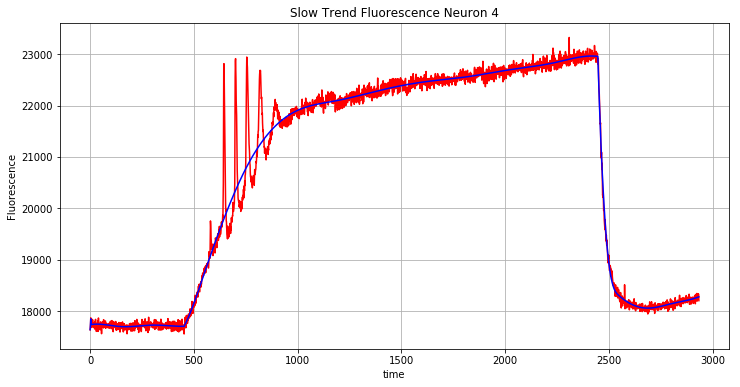

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(T), signal+trends[idx,:], 'r')
ax.plot(np.arange(T), trends[idx,:], 'b')

ax.set(xlabel='time', ylabel='Fluorescence',
       title='Slow Trend Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

# Warm Start Comparison

Brief description of the methods being tested and references... Warm start vs no warm start... solving constrained noise estimation problem with line search (see other notebook).

In [8]:
from trefide.solvers.lagrangian import lpdas, ipm
from trefide.solvers.constrained import cpdas
from trefide.utils.noise import estimate_noise
from timeit import timeit

In [9]:
sizeData = np.arange(1,36) * T
ipm_times = np.zeros((len(signals), len(sizeData)))
lpdas_times = np.zeros((len(signals), len(sizeData)))
cpdas_times = np.zeros((len(signals), len(sizeData)))
lpdas_ws_times = np.zeros((len(signals), len(sizeData)))
cpdas_ws_times = np.zeros((len(signals), len(sizeData)))
for sdx, signal in enumerate(signals):
    for ndx in np.arange(1,len(sizeData)+1):
        target = np.tile(signal, ndx)
        delta = estimate_noise([target], summarize='mean')[0]
        _, _, lam, _ = cpdas(target, delta)
        # Interior Point Method
        def time_ipm():
            _, _, _ = ipm(target, lam)
        ipm_times[sdx, ndx-1] += timeit(time_ipm, number=3)/3
        # Langrangian Primal-Dual Active Set Method
        def time_lpdas():
            _, _, _ = lpdas(target, lam)
        lpdas_times[sdx, ndx-1] += timeit(time_lpdas, number=3)/3
        # Constrianed Primal-Dual Active Set Method
        def time_cpdas():
            _, _, _, _ = cpdas(target, delta)
        cpdas_times[sdx, ndx-1] += timeit(time_cpdas, number=3)/3
        # Warm-Started Langrangian Primal-Dual Active Set Method
        _, l_warm_start, _ = lpdas(target, lam*1.1)
        def time_ws_lpdas():
            _, _, _ = lpdas(target, lam, z_hat=l_warm_start)
        lpdas_ws_times[sdx, ndx-1] = timeit(time_ws_lpdas, number=1)/1
        # Warm Started Constrained Primal-Dual Active Set Method
        _, c_warm_start, _ = lpdas(target, lam*1.1)
        def time_ws_cpdas():
            _, _, _, _ = cpdas(target, delta, z_hat=c_warm_start, lambda_=lam*1.1)
        cpdas_ws_times[sdx, ndx-1] = timeit(time_ws_cpdas, number=1)/1

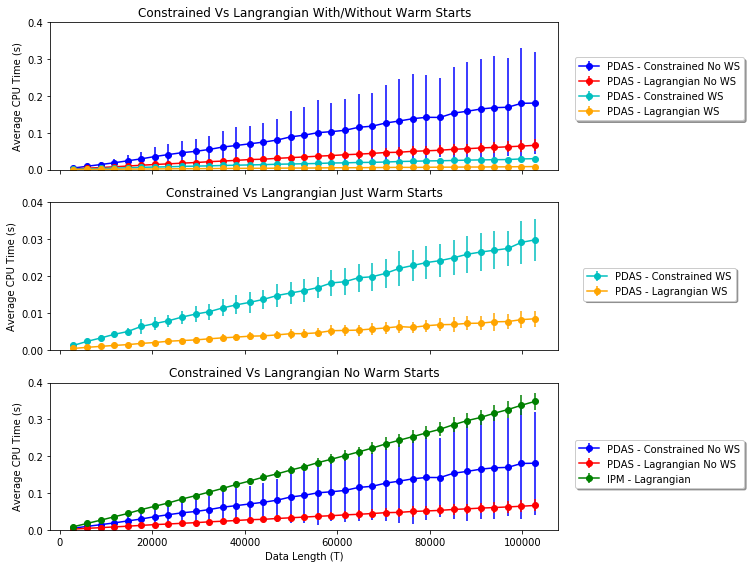

In [10]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,8), sharex=False)

ax = axs[0]
ax.errorbar(sizeData, np.mean(cpdas_times, axis=0), yerr=np.std(cpdas_times, axis=0), marker='o', c='b')
ax.errorbar(sizeData, np.mean(lpdas_times, axis=0), yerr=np.std(lpdas_times, axis=0), marker='o', c='r')
ax.errorbar(sizeData, np.mean(cpdas_ws_times, axis=0), yerr=np.std(cpdas_ws_times, axis=0), marker='o', c='c')
ax.errorbar(sizeData, np.mean(lpdas_ws_times, axis=0), yerr=np.std(lpdas_ws_times, axis=0), marker='o', c='orange')
#ax.set_xlabel('Data Length (T)')
ax.set_ylabel('Average CPU Time (s)')
ax.set_ylim((0,.4))
ax.set_title('Constrained Vs Langrangian With/Without Warm Starts')
plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=6)
ax.legend(['PDAS - Constrained No WS',
           'PDAS - Lagrangian No WS',
           'PDAS - Constrained WS',
           'PDAS - Lagrangian WS'], 
          loc='lower center', 
          bbox_to_anchor=(1.2, .3),
          ncol=1,
          fancybox=True,
          shadow=True)

ax = axs[1]
ax.errorbar(sizeData, np.mean(cpdas_ws_times, axis=0), yerr=np.std(cpdas_ws_times, axis=0), marker='o', c='c')
ax.errorbar(sizeData, np.mean(lpdas_ws_times, axis=0), yerr=np.std(lpdas_ws_times, axis=0), marker='o', c='orange')
#ax.set_xlabel('Data Length (T)')
ax.set_ylabel('Average CPU Time (s)')
ax.set_ylim((0,.04))
ax.set_title('Constrained Vs Langrangian Just Warm Starts')
plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=6)
ax.legend(['PDAS - Constrained WS',
           'PDAS - Lagrangian WS'], 
          loc='lower center', 
          bbox_to_anchor=(1.2, .3),
          ncol=1,
          fancybox=True,
          shadow=True)

ax = axs[2]
ax.errorbar(sizeData, np.mean(cpdas_times, axis=0), yerr=np.std(cpdas_times, axis=0), marker='o', c='b')
ax.errorbar(sizeData, np.mean(lpdas_times, axis=0), yerr=np.std(lpdas_times, axis=0), marker='o', c='r')
ax.errorbar(sizeData, np.mean(ipm_times, axis=0), yerr=np.std(ipm_times, axis=0), marker='o', c='g')
ax.set_xlabel('Data Length (T)')
ax.set_ylabel('Average CPU Time (s)')
ax.set_ylim((0,.4))
ax.set_title('Constrained Vs Langrangian No Warm Starts')
ax.locator_params(nbins=6)

ax.legend(['PDAS - Constrained No WS',
           'PDAS - Lagrangian No WS',
           'IPM - Lagrangian'], 
          loc='lower center', 
          bbox_to_anchor=(1.2, .25),
          ncol=1,
          fancybox=True,
          shadow=True)

fig.tight_layout()
plt.show()

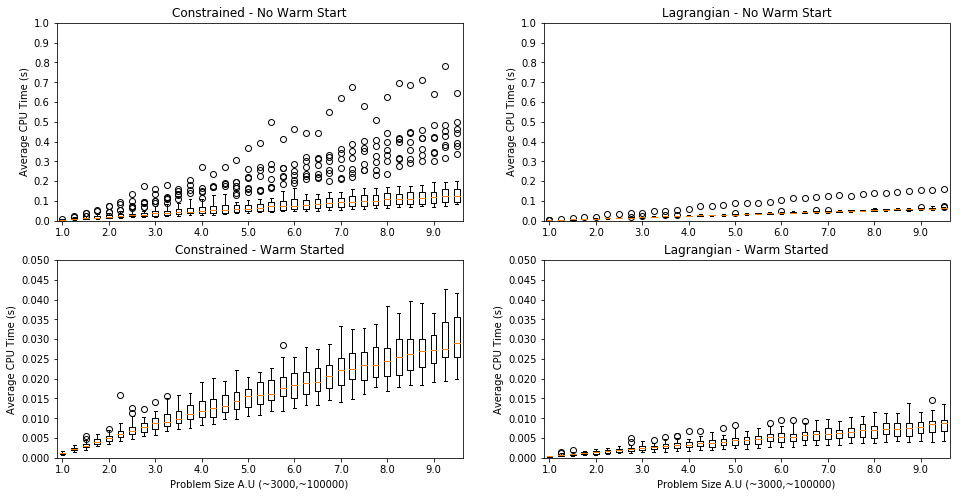

In [11]:
# Now switch to a more OO interface to exercise more features.
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,8), sharex=False)
ax = axs[0,0]
ax.boxplot(cpdas_times, positions=sizeData/T)
#plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=11)
ax.set_ylabel('Average CPU Time (s)')
ax.set_ylim((0,1))
ax.set_title('Constrained - No Warm Start')

ax = axs[0,1]
ax.boxplot(lpdas_times, positions=sizeData/T)
#plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=11)
ax.set_ylabel('Average CPU Time (s)')
ax.set_ylim((0,1))
ax.set_title('Lagrangian - No Warm Start')

ax = axs[1,0]
ax.boxplot(cpdas_ws_times, positions=sizeData/T)
#plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=11)
ax.set_ylabel('Average CPU Time (s)')
ax.set_xlabel('Problem Size A.U (~3000,~100000)')
ax.set_ylim((0,.05))
ax.set_title('Constrained - Warm Started')

ax = axs[1,1]
ax.boxplot(lpdas_ws_times, positions=sizeData/T)
#plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=11)
ax.set_ylabel('Average CPU Time (s)')
ax.set_xlabel('Problem Size A.U (~3000,~100000)')
ax.set_ylim((0,.05))
ax.set_title('Lagrangian - Warm Started')


#fig.tight_layout()
plt.show()

These results were with a 2.5 GHz Intel Core i7 processor on a system running MacOS High Sierra 10.13.3, the Intel Distribtuion for Python 3.6.3, Cython 0.27.3, and Intel MKL 2018. Source compiled using Intel's icc version 18.0.2.164.